# Visualize Maps

This notebooks contains code to generate contact maps and dendrograms from hierarchical clustering for the *Pan* 3D genome project.

## Table of Contents

- [Notebook Setup](#notebooksetup)
- [Simple Individual Maps](#simpleindividualmaps)
- [Simple Comparison](#simplecomparison)
- [Chr21 Window Dendrograms](#chr21windowdendrograms)
- [Western Chimpanzee Divergent Window Annotated Comparisons](#westernchimpanzeecomparisons)
- [Example Bonobo-Chimpanzee Divergent Window Comparisons](#examplebonobochimpanzeecomparisons)
- [*MYO10* Bonobo-Chimpanzee Comparison](#myo10comparison)
- [*In Silico* Mutagenesis Map Comparison](#insilicomutagenesiscomparison)

## Notebook Setup <a class = 'anchor' id = 'notebooksetup'></a>

Load packages for maps and dendrograms.

In [1]:
from matplotlib import colors
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
from mpl_toolkits.axisartist.grid_finder import DictFormatter
from scipy.spatial.distance import pdist # <- for dendrograms
import json
import math
import matplotlib.font_manager as font_manager
import matplotlib.lines as mlines
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist.floating_axes as floating_axes
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch # <- for dendrograms

Set path to Arial font.

In [2]:
arial_path = '/wynton/home/capra/cbrand/miniconda3/envs/jupyter/fonts/Arial.ttf'
arial = font_manager.FontProperties(fname = arial_path)

Write functions use to visualize contact maps. The first two are from the original Akita paper while the third rotates the map to create a diamond. We will mask the lower part of the triangle later. The fourth function loads the Akita predictions for a given individual at a specific window.

In [3]:
def set_diag(arr, x, i=0):
    start = max(i, -arr.shape[1] * i)
    stop = max(0, (arr.shape[1] - i)) * arr.shape[1]
    step = arr.shape[1] + 1
    arr.flat[start:stop:step] = x
    return arr

In [4]:
def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

In [5]:
def setup_axes1(fig, rect, angle):
    tr = Affine2D().scale(2, 2).rotate_deg(angle)

    # Create dictionarys to keep the x-ticks and y-ticks after the rotation
    dictio={i:str(val) for i,val in enumerate(np.arange(-.5, 449, 10).tolist())}
    reversedictio={i:dictio[val] for i,val in enumerate(list(reversed(sorted(dictio.keys()))))}
    grid_helper = floating_axes.GridHelperCurveLinear(
        tr, extremes=(-0.5, 448.5,-0.5, 448.5), tick_formatter1= DictFormatter(dictio),
        tick_formatter2=DictFormatter(reversedictio))

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    
    # remove axes
    ax1.axis("off")    
    ax1.axis["bottom"].set_visible(False)
    ax1.axis["top"].set_visible(False)
    ax1.axis["right"].set_visible(False)
    ax1.axis["left"].set_visible(False)


    fig.add_subplot(ax1) 
    aux_ax = ax1.get_aux_axes(tr)
    grid_helper.grid_finder.grid_locator1._nbins = 448    #Number of rows
    grid_helper.grid_finder.grid_locator2._nbins = 448    #Number of columns
    return aux_ax

In [6]:
def load_individual_map(chr, start, ind):
    with open(f'/wynton/group/capra/projects/pan_3d_genome/data/predictions/samples/3d_predictions_HFF_{ind}_{chr}.txt') as file:
        lines = [ line.strip() for line in file ]
        for line in lines:
            if (f'{chr}\t{start}') in line:
                ind_vector = line.split('\t')
                ind_vector = ind_vector[2:]
    ind_mat = from_upper_triu(ind_vector, 448, 2)
    mask =  np.tri(ind_mat.shape[0], k = -1)
    ind_mat = np.ma.array(ind_mat, mask = mask).T
    return ind_mat

## Simple Individual Maps <a class = 'anchor' id = 'simpleindividualmaps'></a>

Generate a single contact map without x axis tick labels or other annotations.

In [7]:
def individual_map(ind1, window):
    chr = window.split('_')[0]
    start = int(window.split('_')[1])
    
    ind1_mat = load_individual_map(chr, start, ind1)

    # rotate matrix and add color
    fig1, axes=plt.subplots(1,figsize=(20,20))
    fig1.delaxes(axes)
    ax = setup_axes1(fig1, 111, -45)
    
    ax.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -1, vmax = 1)
    #plt.matshow(ind1_mat, cmap = 'RdBu_r')
    
    # add border to map
    ax.plot([-1, 447], [0, 448], color = 'black', linewidth = 3.5) # bottom line
    ax.plot([-1, 447], [448, 448], color = 'black', linewidth = 3.5) # right line
    ax.plot([-1, -1], [448, 0], color = 'black', linewidth = 3.5) # left line
    
    # add 'x-axis' ticks
    first = start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/2048
    
    x_list = np.arange(cell, 440, (100000/2048))
    for x in x_list:
        ax.plot(x, x, color = 'black', marker = '|', markersize = 20)
    
    plt.savefig('/wynton/group/capra/projects/pan_3d_genome/figures/main_fig_components/individual_map_%s_%s.pdf' % (window, ind1), bbox_inches = 'tight', transparent = True);
    plt.show()

Generate some maps for Figure 1B.

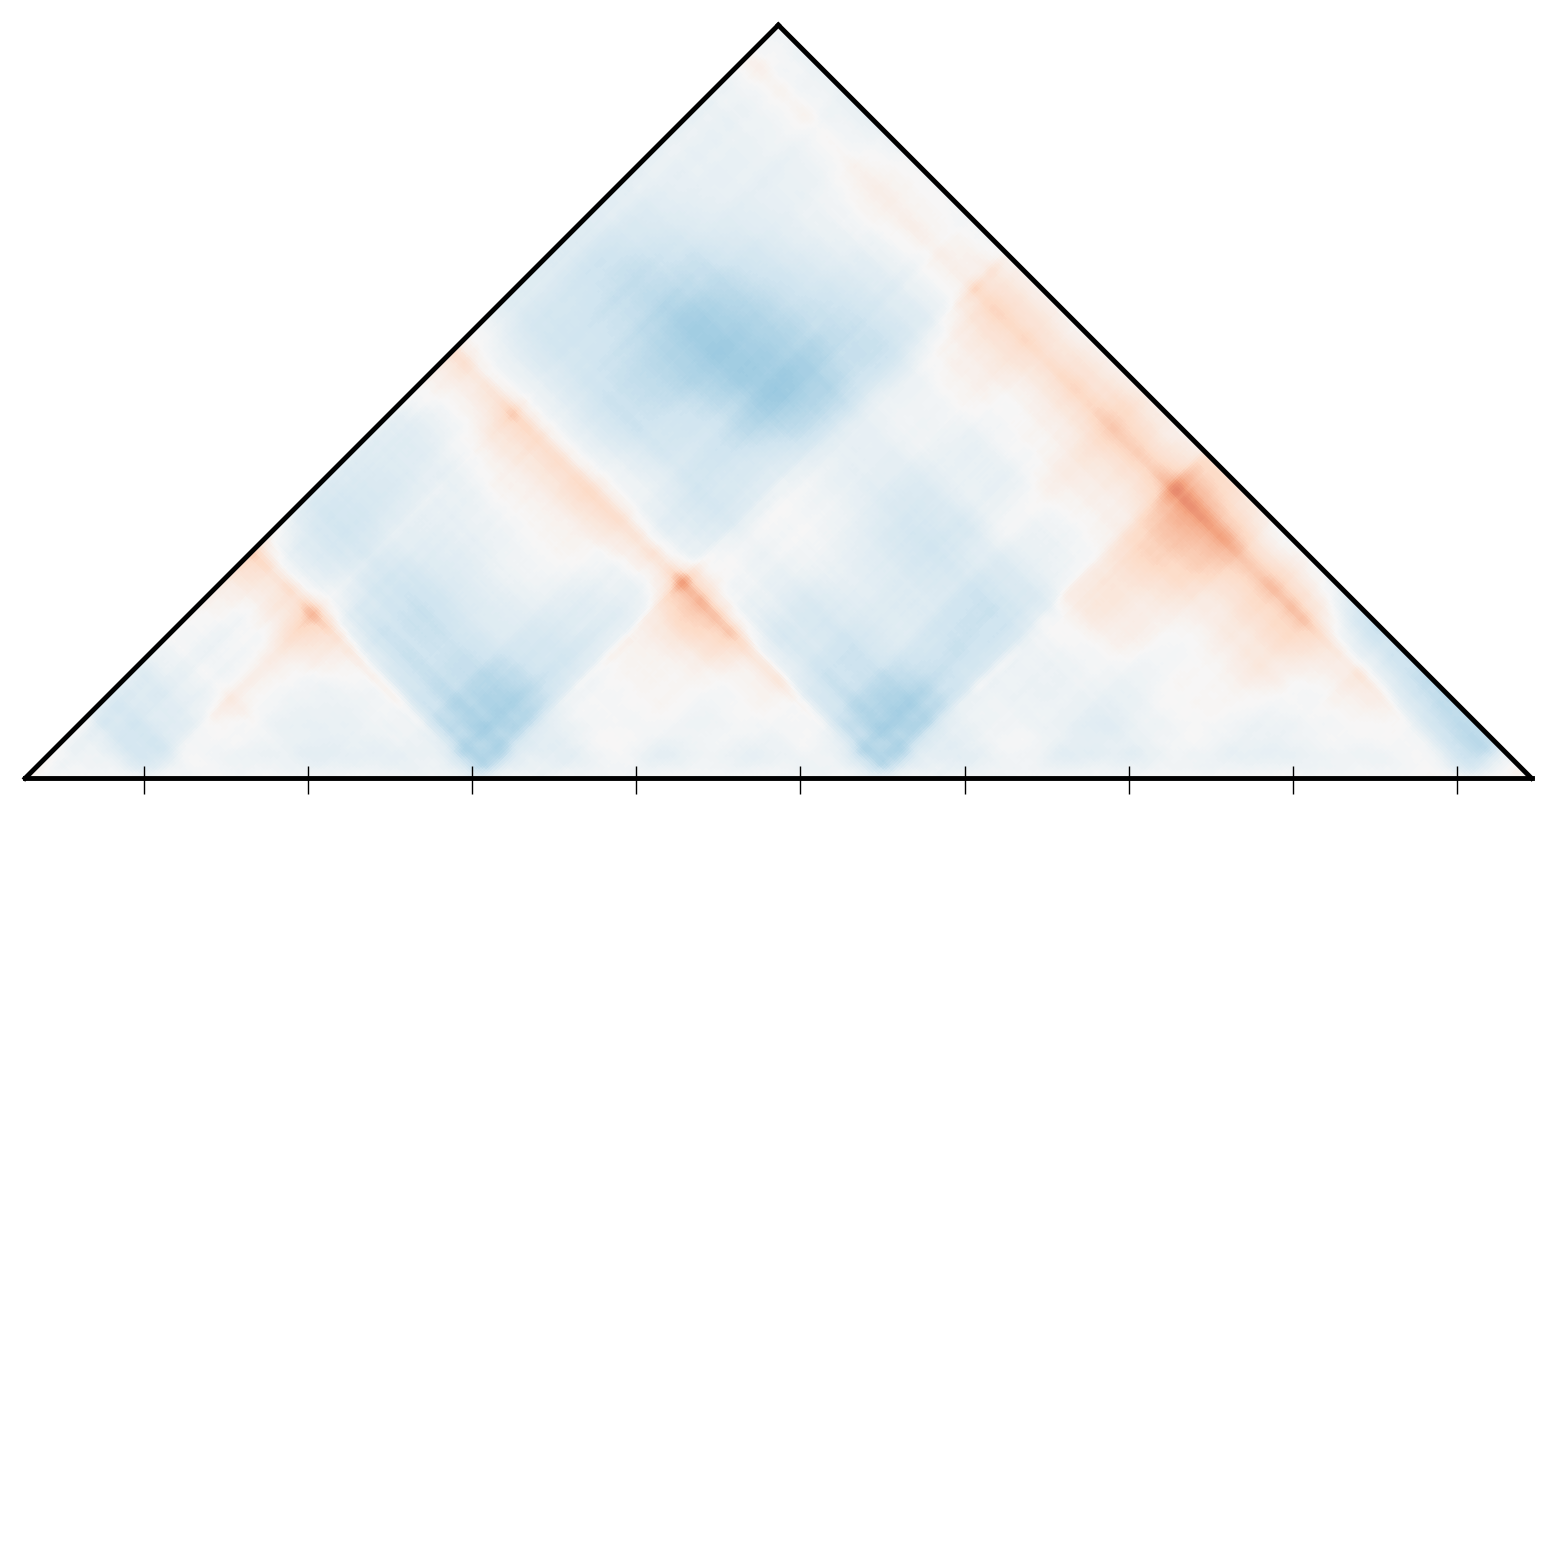

In [8]:
individual_map('Clint', 'chr1_100663296')

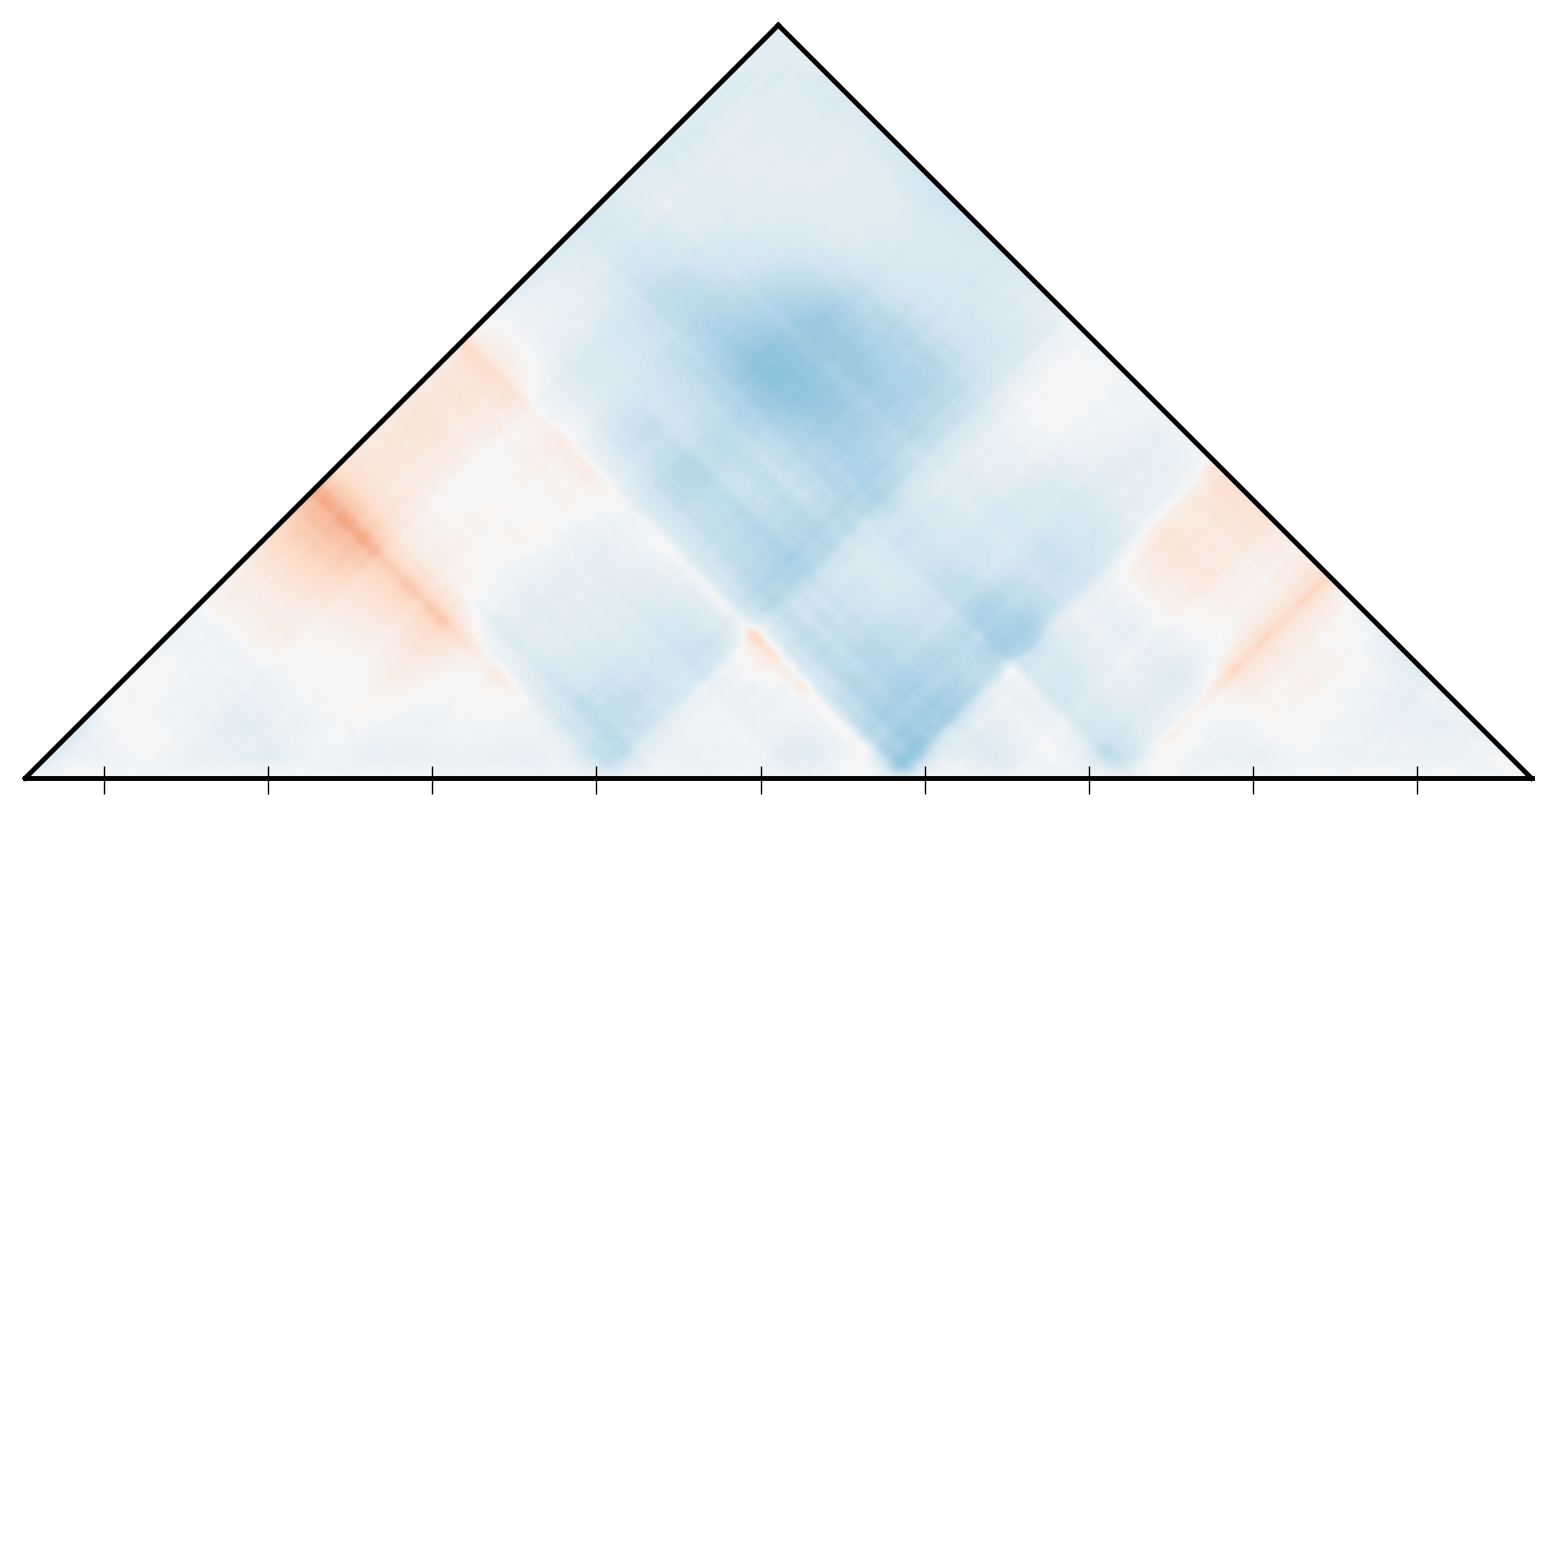

In [9]:
individual_map('Clint', 'chr1_101187584')

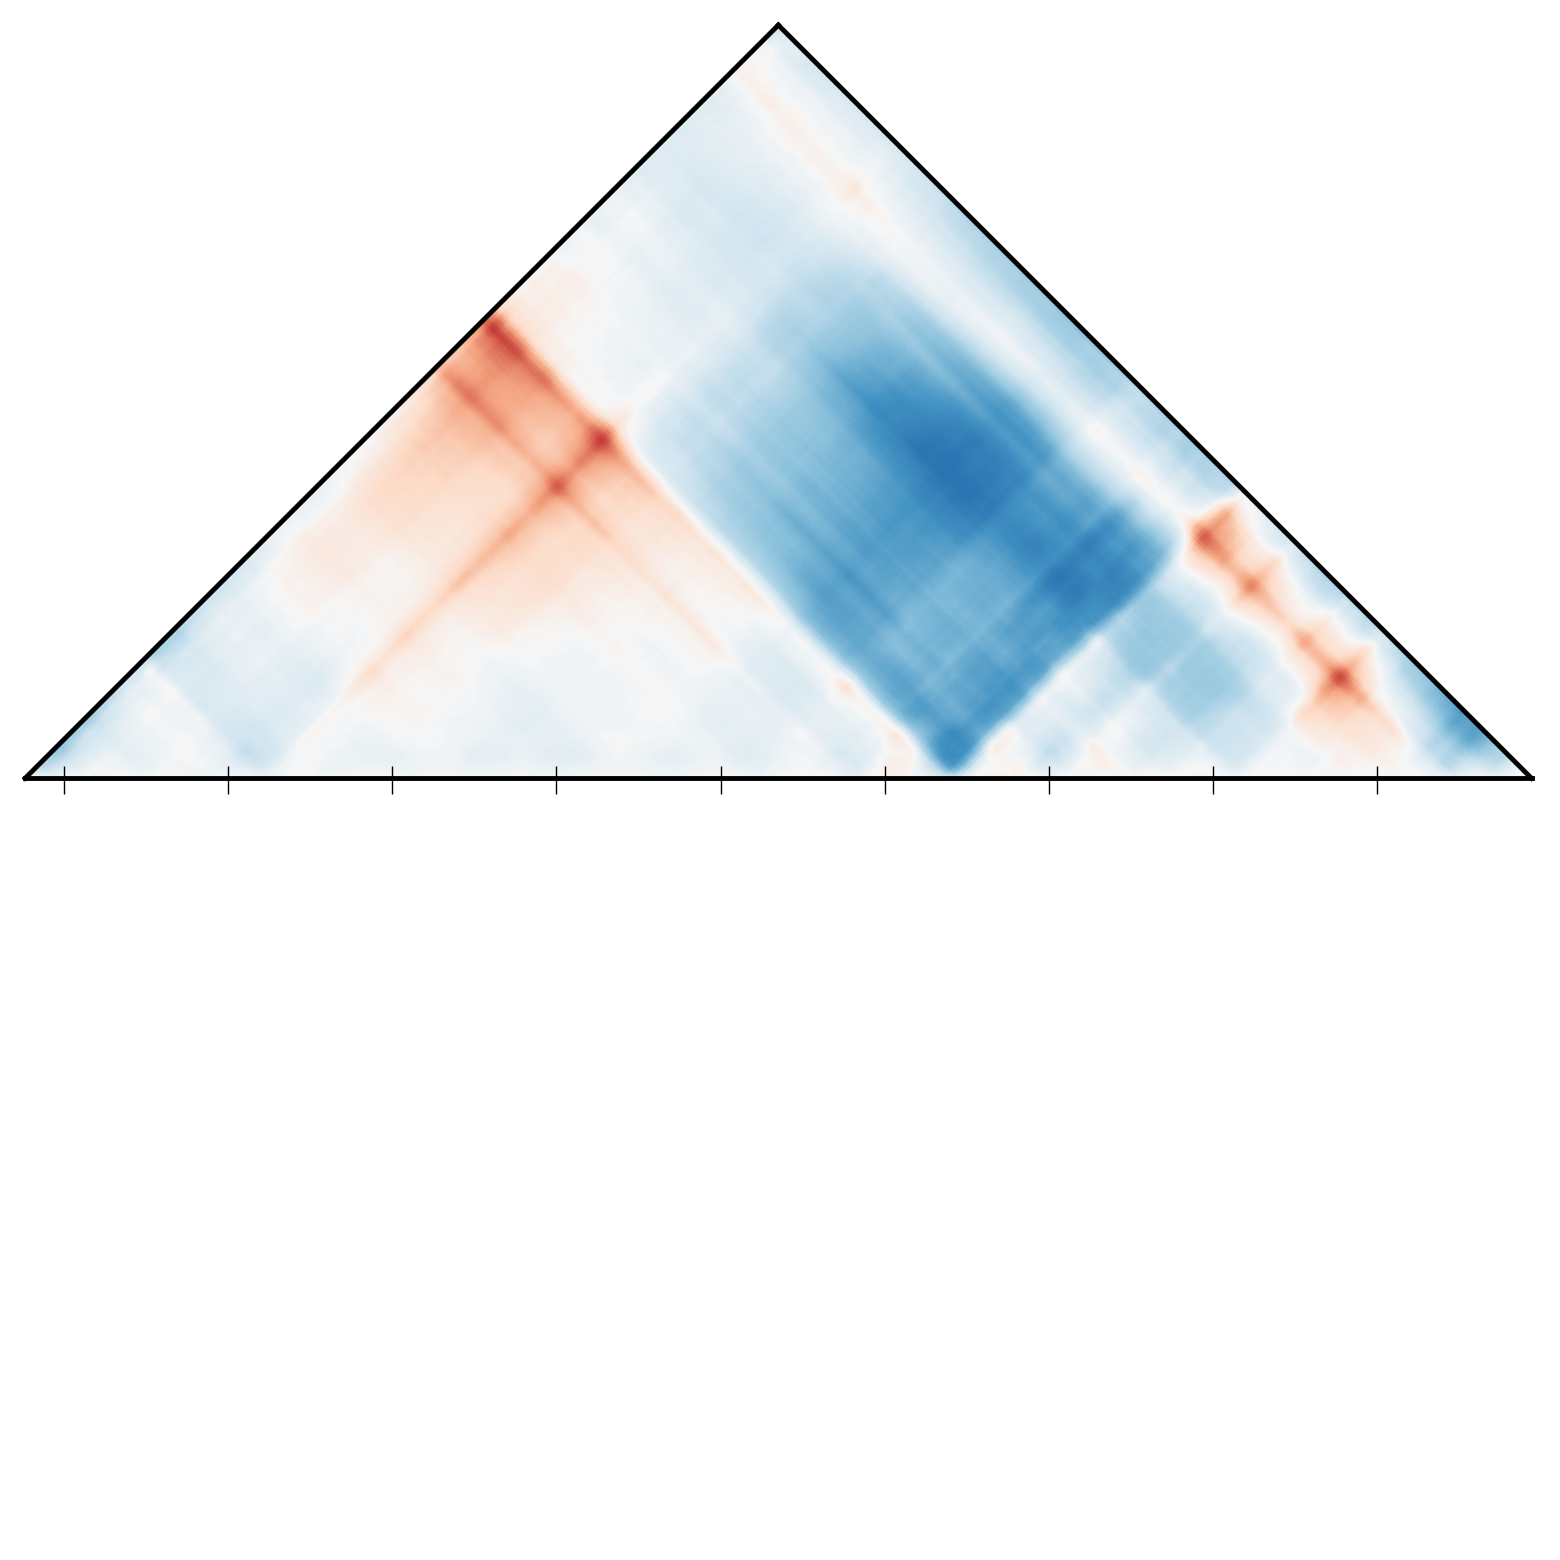

In [10]:
individual_map('Clint', 'chr1_101711872')

Generate two example maps for the divergence metric explanation in Figure 1C.

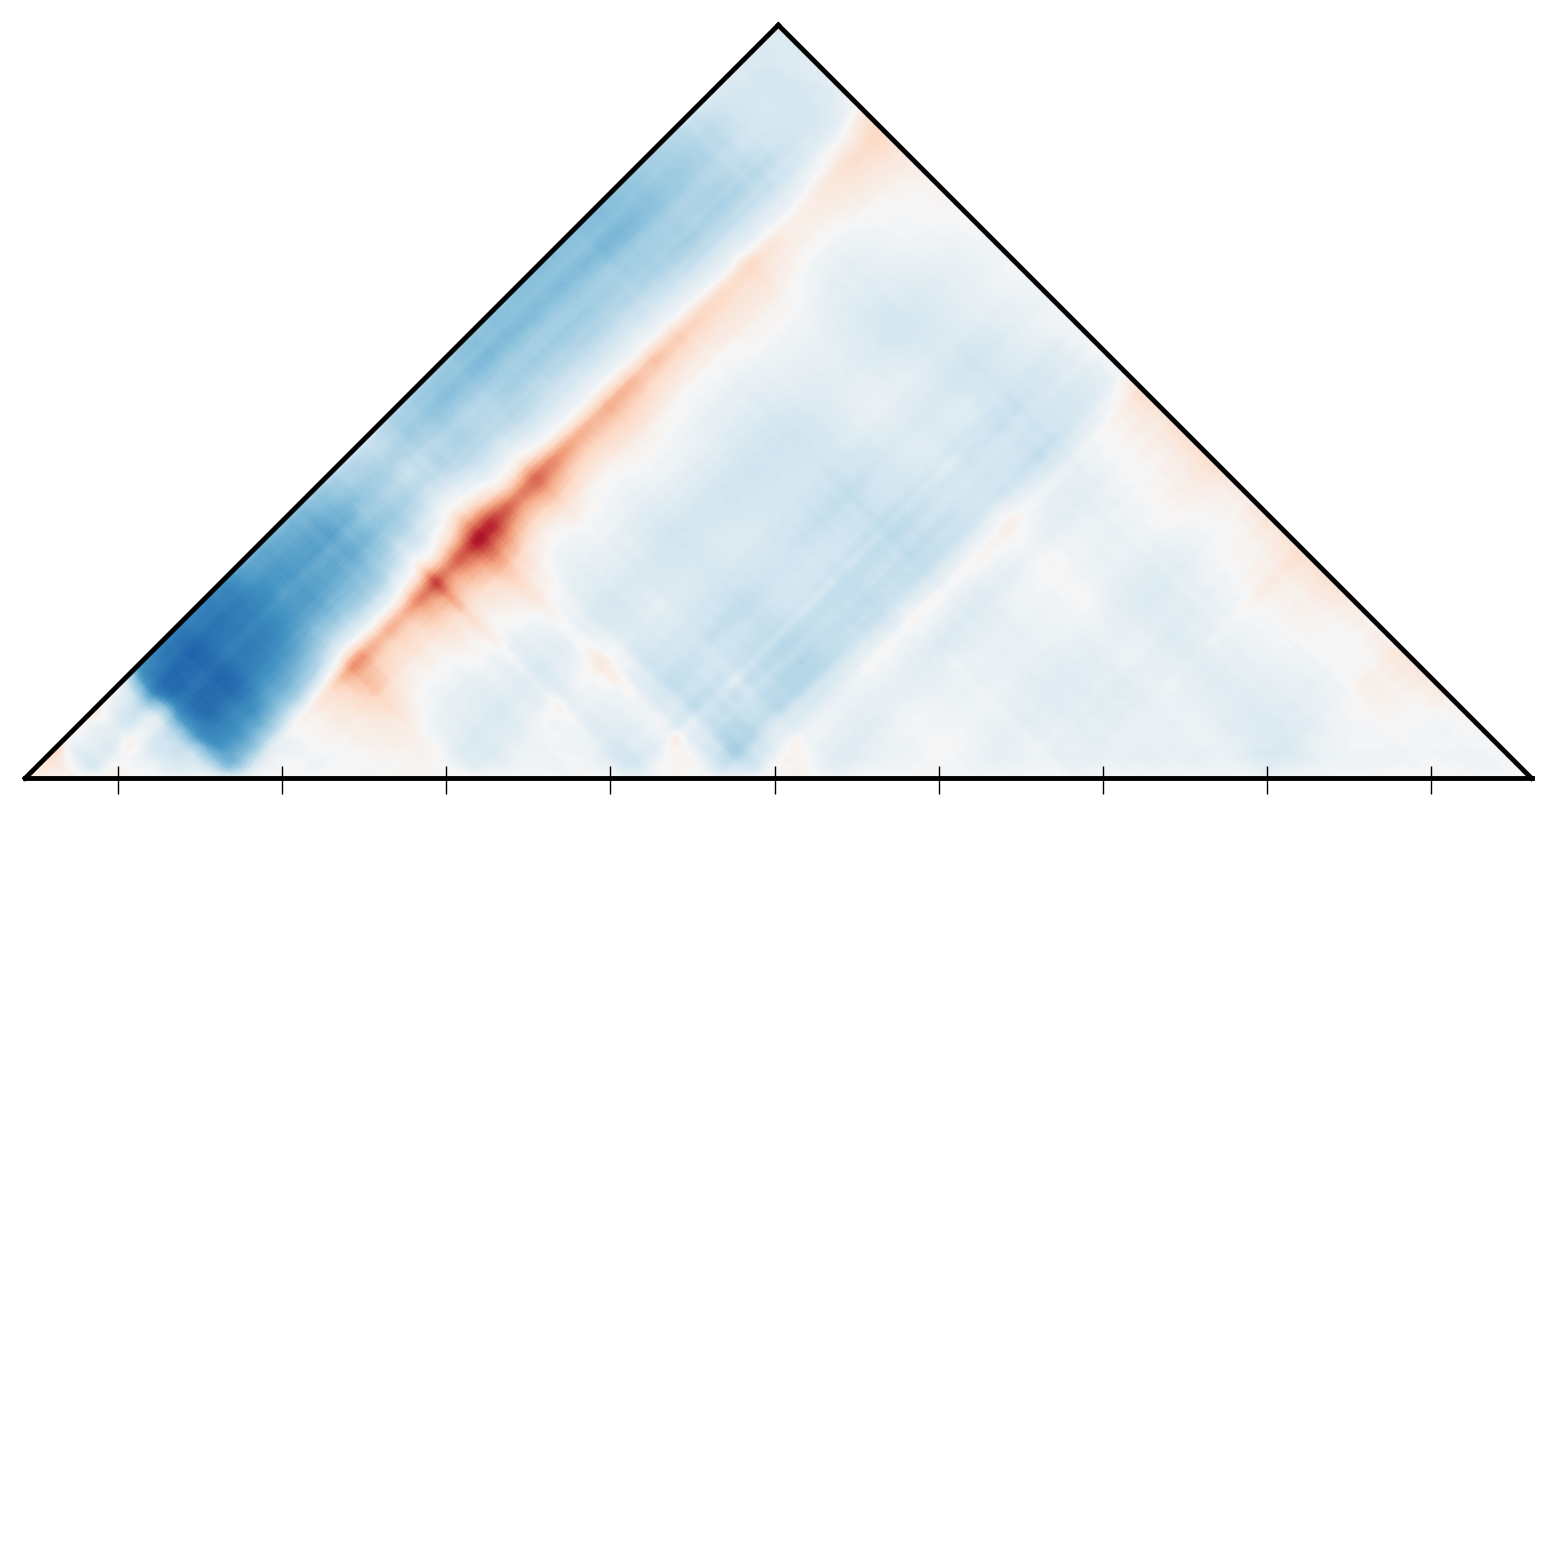

In [11]:
individual_map('Alfred', 'chr8_107479040')

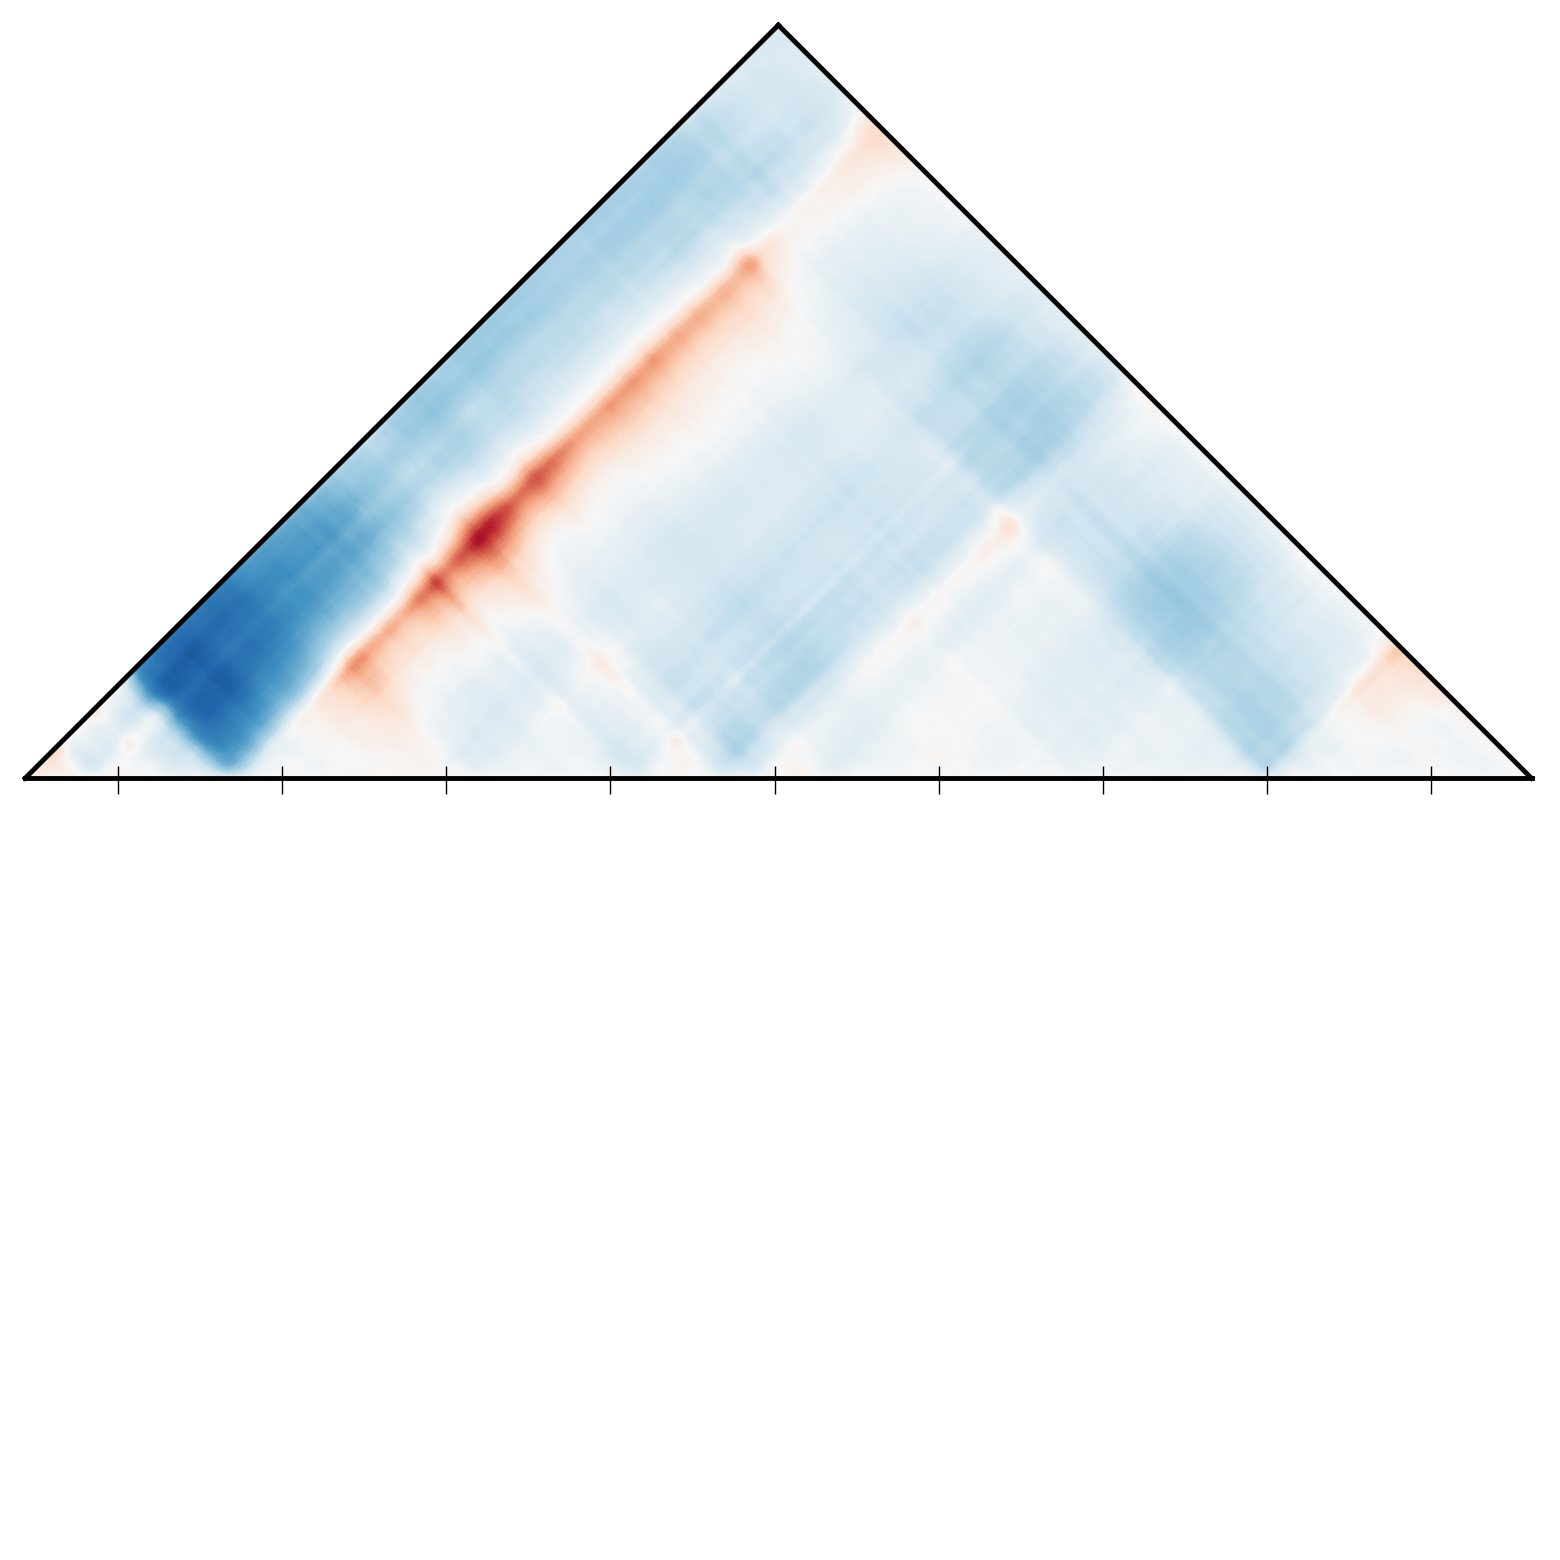

In [12]:
individual_map('Bwamble', 'chr8_107479040')

## Simple Comparison <a class = 'anchor' id = 'simplecomparison'></a>

In [13]:
def simple_map_comparison(ind1, ind2, window):
    chr = window.split('_')[0]
    start = int(window.split('_')[1])
    
    ind1_mat = load_individual_map(chr, start, ind1)
    ind2_mat = load_individual_map(chr, start, ind2)

    fig1, axes = plt.subplots(3, 1, figsize=(2.5,6))

    fig1.delaxes(axes[0])
    fig1.delaxes(axes[1])
    fig1.delaxes(axes[2])
    
    ax0 = setup_axes1(fig1, 311, -45)
    ax1 = setup_axes1(fig1, 312, -45)
    ax2 = setup_axes1(fig1, 313, -45)

    ax0.set_position([0, 0.62, 1, 1])
    ax1.set_position([0, 0.31, 1, 1])
    ax2.set_position([0, 0, 1, 1])
    
    ax0.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -1, vmax = 1)
    ax1.matshow(ind2_mat, cmap = 'RdBu_r', vmin = -1, vmax = 1)
    ax2.matshow(ind2_mat - ind1_mat, cmap = 'PRGn_r', vmin = -0.5, vmax = 0.5)
    
    subplots = [ax0,ax1,ax2]
    
    # add border to map
    for n in subplots:
        n.plot([-1, 447], [0, 448], color = 'black', linewidth = 0.70821529745) # bottom line
        n.plot([-1, 447], [448, 448], color = 'black', linewidth = 0.70821529745) # right line
        n.plot([-1, -1], [448, 0], color = 'black', linewidth = 0.70821529745) # left line
    
    # add 'x-axis' ticks
    first = start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/2048
    
    x_list = np.arange(cell, 440, (100000/2048))
        
    for n in subplots:
        for x in x_list:
            n.plot(x, x, color = 'black', marker = '|', markersize = 5)
    
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for n in subplots:
        for x, y in zip(x_list[::2], (y_list[::2])):
            n.text(x+15, x-15, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontproperties = arial, fontsize = 9)
    
    # subpanel labels
    ax0.text(290, 158, ind1, horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    ax1.text(290, 158, ind2, horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    ax2.text(290, 158, r'$\Delta$', horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    
    plt.savefig('/wynton/group/capra/projects/pan_3d_genome/figures/main_fig_components/simple_comparison_%s_%s_%s.pdf' % (window, ind1, ind2), bbox_inches = 'tight', transparent = True, dpi = 400);
    plt.show()

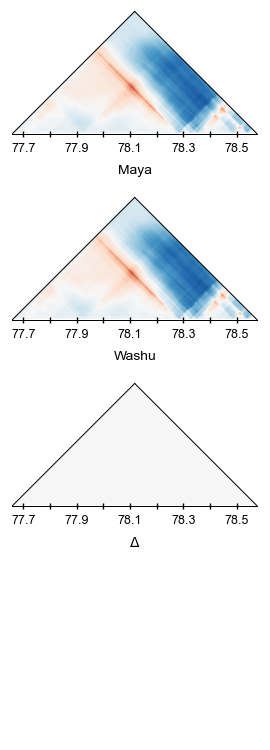

In [14]:
simple_map_comparison('Maya', 'Washu', 'chr4_77594624')

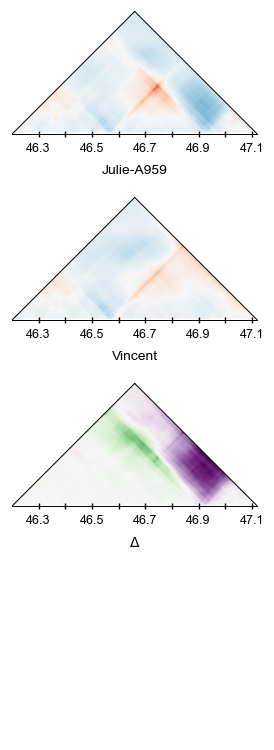

In [15]:
simple_map_comparison('Julie-A959', 'Vincent', 'chr18_46137344')

## Chr21 Window Dendrograms <a class = 'anchor' id = 'chr21windowdendrograms'></a>

Now let's write a function to visualize the dendrogram for a given window. The five arguments include the window ID and the x coordinates for the cluster starts and stops. This code works for a window with two clusters but the code can be easily adjusted for 1 or > 2 clusters. 

In [16]:
comparisons = pd.read_csv('/wynton/group/capra/projects/pan_3d_genome/data/dataframes/HFF_comparisons.txt', sep = '\t', header = 0)

In [17]:
def get_chr21_window_dendrogram(window, cluster_1_start, cluster_1_end, cluster_2_start, cluster_2_end):
    window_df = comparisons[comparisons['window'] == window]
    idx = sorted(set(window_df['ind1']).union(window_df['ind2']))
    array = window_df.pivot(index='ind1', columns='ind2', values='divergence').reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
    
    fig, ax = plt.subplots(1, figsize=(6.5,2.2))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    condensed = array[np.triu_indices(56, k = 1)]
    dendrogram = sch.dendrogram(sch.linkage(condensed, method = 'complete'), no_labels = True, color_threshold = 0, above_threshold_color = 'darkgrey')
    
    # let's add colored nodes for all leaves to indicate the lineage
    leaf_x = [(x * 10)+5 for x in dendrogram['leaves']]
    leaf_y = [0] * 56
    
    # set leaf colors
    ppn_color = '#829a2d'
    pte_color = '#d77d85'
    pts_color = '#cfaf53'
    ptt_color = '#d29063'
    ptv_color = '#c38dad'
    
    lineage_dict = {8:'ppn',19:'ppn',21:'ppn',24:'ppn',25:'ppn',32:'ppn',33:'ppn',35:'ppn',44:'ppn',
                 0:'pte',18:'pte',29:'pte',34:'pte',47:'pte',
                 3:'pts',4:'pts',6:'pts',11:'pts',12:'pts',15:'pts',17:'pts',22:'pts',26:'pts',30:'pts',40:'pts',41:'pts',43:'pts',49:'pts',50:'pts',53:'pts',54:'pts',
                 1:'ptt',7:'ptt',10:'ptt',13:'ptt',20:'ptt',23:'ptt',28:'ptt',36:'ptt',38:'ptt',39:'ptt',42:'ptt',45:'ptt',48:'ptt',51:'ptt',52:'ptt',55:'ptt',
                 2:'ptv',5:'ptv',9:'ptv',14:'ptv',16:'ptv',27:'ptv',31:'ptv',37:'ptv',46:'ptv'}
    
    colors = {85:ppn_color,195:ppn_color,215:ppn_color,245:ppn_color,255:ppn_color,325:ppn_color,335:ppn_color,355:ppn_color,445:ppn_color,
                 5:pte_color,185:pte_color,295:pte_color,345:pte_color,475:pte_color,
                 35:pts_color,45:pts_color,65:pts_color,115:pts_color,125:pts_color,155:pts_color,175:pts_color,225:pts_color,265:pts_color,305:pts_color,405:pts_color,415:pts_color,435:pts_color,495:pts_color,505:pts_color,535:pts_color,545:pts_color,
                 15:ptt_color,75:ptt_color,105:ptt_color,135:ptt_color,205:ptt_color,235:ptt_color,285:ptt_color,365:ptt_color,385:ptt_color,395:ptt_color,425:ptt_color,455:ptt_color,485:ptt_color,515:ptt_color,525:ptt_color,555:ptt_color,
                 25:ptv_color,55:ptv_color,95:ptv_color,145:ptv_color,165:ptv_color,275:ptv_color,315:ptv_color,375:ptv_color,465:ptv_color}
    
    new_colors = [colors[i] for i in leaf_x]
   
    # create new x for plotting leaves
    new_leaf_x = range(5,565,10)
    
    # plot leaves
    #plt.scatter(new_leaf_x, leaf_y, c = new_colors, edgecolors = 'black', linewidth = 0.5, zorder = 10) # as points
    for x, y, z in zip(new_leaf_x, leaf_y, new_colors): # as rectangles
        rect = Rectangle((x-4.5, y-0.008), width = 9, height = 0.008, facecolor = z, zorder = 10)
        #rect = Rectangle((x-4.5, y-0.008), width = 9, height = 0.008, facecolor = z, edgecolor = 'black', linewidth = 0.5, zorder = 10)
        ax.add_patch(rect)
    
    plt.plot([cluster_1_start, cluster_1_end], [-0.012, -0.012], color = 'black', linewidth = 1) # cluster 1 line
    plt.plot([cluster_2_start, cluster_2_end], [-0.012, -0.012], color = 'black', linewidth = 1) # cluster 2 line
    
    plt.xlim(left = -10)
    plt.ylim(top = 0.13)
    plt.ylim(bottom = -0.0122)
    plt.yticks(np.arange(0, 0.15, 0.03))
    
    plt.xlabel('Individuals', fontproperties = arial, size = 10) # label of the x-axis
    plt.ylabel('3D Divergence\n', fontproperties = arial, size = 10) # label of the y-axis
    plt.yticks(fontproperties = arial, fontsize = 9)
    
    plt.savefig('/wynton/group/capra/projects/pan_3d_genome/figures/main_fig_components/%s_tree.pdf' % (window), bbox_inches = 'tight', transparent = True)
    plt.show()

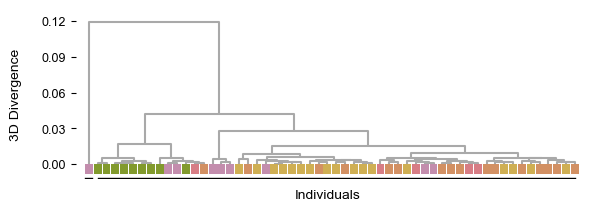

In [18]:
get_chr21_window_dendrogram('chr21_5242880', 1, 9, 15, 555)

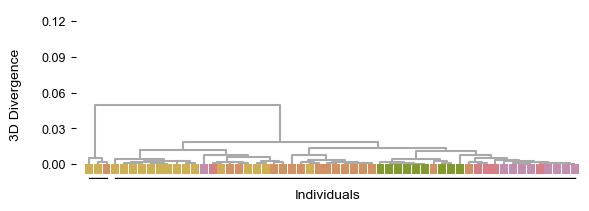

In [19]:
get_chr21_window_dendrogram('chr21_16252928', 5, 25, 35, 555)

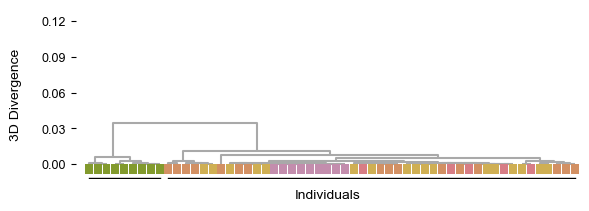

In [20]:
get_chr21_window_dendrogram('chr21_24117248', 5, 85, 95, 555)

## Western Chimpanzee Divergent Window Annotated Comparisons <a class = 'anchor' id = 'westernchimpanzeecomparisons'></a>

Write a function to add annotations to a plot. Annotations include the genes, phastCons conserved elements, and CTCF binding sites from Schwalie et al. 2013.

In [21]:
def annotations(chr, start):
    # assign a few variables for the "tracks" below
    map_x_min = (start+65536)
    map_x_max = (start+((2**20)-65536))
            
    # exons
    exons = pd.read_csv('/wynton/group/capra/projects/pan_3d_genome/data/annotations/panTro6_exons.bed', sep = '\t', header = None, names = ['chr','start','end','gene'])
    exons = exons[(exons['chr'] == chr) & (exons['start'] >= start) & (exons['start'] < map_x_max)]
    exons['end'].values[exons['end'] > map_x_max] = map_x_max
    
    exons['start'] = (exons['start'] - (start + 65536)) / 2048
    exons['end'] = (exons['end'] - (start + 65536)) / 2048
    exons['length'] = exons['end'] - exons['start']
    exons = exons[exons['end'] >= 0] # remove values less than zero
    
    exon_genes = pd.unique(exons['gene']).tolist()
    exon_starts = exons['start'].values.tolist()
    exon_lengths = exons['length'].values.tolist()

    # genes
    genes = pd.read_csv('/wynton/group/capra/projects/pan_3d_genome/data/annotations/panTro6_genes.bed', sep = '\t', header = None, names = ['chr','start','end','transcript','gene'])
    genes = genes[genes['gene'].isin(exon_genes)]
    
    genes['start'].values[genes['start'] < map_x_min] = map_x_min
    genes['end'].values[genes['end'] > map_x_max] = map_x_max
    genes['start'] = (genes['start'] - map_x_min) / 2048
    genes['end'] = (genes['end'] - map_x_min) / 2048
  
    genes['length'] = genes['end'] - genes['start']
    gene_starts = genes['start'].values.tolist()
    gene_lengths = genes['length'].values.tolist()
    
    # gene names
    gene_midpoints = (genes['length']/2) + genes['start'].values.tolist()

    # phastCons
    phastCons = pd.read_csv('/wynton/group/capra/projects/pan_3d_genome/data/phastCons/phastConsElements30way_panTro6.bed', sep = '\t', header = None, names = ['chr','start','end','score'])
    phastCons = phastCons[(phastCons['chr'] == chr) & (phastCons['start'] >= start) & (phastCons['start'] < start+((2**20)-65536))]
    phastCons['end'].values[phastCons['end'] > map_x_max] = map_x_max
    phastCons['start'] = (phastCons['start'] - (start + 65536)) / 2048
    phastCons['end'] = (phastCons['end'] - (start + 65536)) / 2048
    phastCons['length'] = phastCons['end'] - phastCons['start']
    phastCons_starts = phastCons['start'].values.tolist()
    phastCons_lengths = phastCons['length'].values.tolist()
    
    # CTCF
    CTCF = pd.read_csv('/wynton/group/capra/projects/pan_3d_genome/data/annotations/panTro6_CTCF.bed', sep = '\t', header = None, names = ['chr','start','end','score','18359_overlap','36222_overlap','EB176_overlap'])
    CTCF = CTCF[(CTCF['chr'] == chr) & (CTCF['start'] >= start) & (CTCF['start'] < start+((2**20)-65536))]
    CTCF['end'].values[CTCF['end'] > map_x_max] = map_x_max
    CTCF['start'] = (CTCF['start'] - (start + 65536)) / 2048
    CTCF['end'] = (CTCF['end'] - (start + 65536)) / 2048
    CTCF['length'] = CTCF['end'] - CTCF['start']
    CTCF_starts = CTCF['start'].values.tolist()
    CTCF_lengths = CTCF['length'].values.tolist()

    return exon_starts, exon_lengths, gene_starts, gene_lengths, gene_midpoints, exon_genes, phastCons_starts, phastCons_lengths, CTCF_starts, CTCF_lengths

In [22]:
def western_chimpanzee_divergent_window_map_comparison(ind1, ind2, window, save):
    chr = window.split('_')[0]
    start = int(window.split('_')[1])
    
    ind1_mat = load_individual_map(chr, start, ind1)
    ind2_mat = load_individual_map(chr, start, ind2)

    fig1, axes = plt.subplots(3, 1, figsize=(1.7,4.8))

    fig1.delaxes(axes[0])
    fig1.delaxes(axes[1])
    fig1.delaxes(axes[2])
    
    ax0 = setup_axes1(fig1, 311, -45)
    ax1 = setup_axes1(fig1, 312, -45)
    ax2 = setup_axes1(fig1, 313, -45)

    ax0.set_position([0, 0.66, 1, 1])
    ax1.set_position([0, 0.35, 1, 1])
    ax2.set_position([0, 0.04, 1, 1])
    
    ax0.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -2, vmax = 2)
    ax1.matshow(ind2_mat, cmap = 'RdBu_r', vmin = -2, vmax = 2)
    ax2.matshow(ind2_mat - ind1_mat, cmap = 'PRGn_r', vmin = -1, vmax = 1)
    
    subplots = [ax0,ax1,ax2]
    
    # add border to map
    for n in subplots:
        n.plot([-1, 447], [0, 448], color = 'black', linewidth = 0.70821529745) # bottom line
        n.plot([-1, 447], [448, 448], color = 'black', linewidth = 0.70821529745) # right line
        n.plot([-1, -1], [448, 0], color = 'black', linewidth = 0.70821529745) # left line
    
    # add 'x-axis' ticks
    first = start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/2048
    
    x_list = np.arange(cell, 440, (100000/2048))
        
    for n in subplots:
        for x in x_list:
            n.plot(x, x, color = 'black', marker = '|', markersize = 5)
    
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for n in subplots:
        for x, y in zip(x_list[::2], (y_list[::2])):
            n.text(x+15, x-15, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontproperties = arial, fontsize = 6)
    
    # subpanel labels
    ax0.text(290, 158, 'Western Chimpanzee', horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 6)
    ax1.text(290, 158, 'Non-Western Chimpanzee', horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 6)
    ax2.text(290, 158, r'$\Delta$', horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 6)
    
    # get annotations
    exon_starts, exon_lengths, gene_starts, gene_lengths, gene_midpoints, exon_genes, phastCons_starts, phastCons_lengths, CTCF_starts, CTCF_lengths = annotations(chr, start)
    
    # plot tracks
    for x, y in zip(exon_starts, exon_lengths):
        ax2.add_patch(Rectangle((x+100, x-100), width = y, height = 25*0.75, angle = 45, color = 'black', lw = 1))
    for x, y in zip(gene_starts, gene_lengths):
        ax2.plot([(x+93.5), ((x+y)+93.5)],[(x-93.5), ((x+y)-93.5)], color = 'black') # line will default to bottom of exon rectangle so adjust coordinates if exon height changes
    for x, y in zip(gene_midpoints, exon_genes):
        ax2.text(x+105, x-105, y, horizontalalignment = 'center', verticalalignment = 'top', style = 'italic', fontsize = 4.8)
    for x, y in zip(CTCF_starts, CTCF_lengths):
        ax2.add_patch(Rectangle((x+145, x-145), width = y, height = 25*0.75, angle = 45, color = 'grey', lw = 1))
    for x, y in zip(phastCons_starts, phastCons_lengths):
        ax2.add_patch(Rectangle((x+175, x-175), width = y, height = 25*0.75, angle = 45, color = 'goldenrod', lw = 1))

    # track labels
    for n in subplots:
        n.text(0, -36, chr, horizontalalignment = 'right', verticalalignment = 'top', fontproperties = arial, fontsize = 6)
    
    ax2.text(37.5, -82.5, 'Genes', horizontalalignment = 'right', verticalalignment = 'center', fontproperties = arial, fontsize = 6)
    ax2.text(87.5, -127.5, 'CTCF', horizontalalignment = 'right', verticalalignment = 'center', fontproperties = arial, fontsize = 6)
    ax2.text(117.5, -157.5, 'Cons', horizontalalignment = 'right', verticalalignment = 'center', fontproperties = arial, fontsize = 6)

    plt.subplots_adjust(hspace=0.5)
    
    # save and show plot
    if save == 'yes':
        plt.savefig('/wynton/group/capra/projects/pan_3d_genome/figures/suppl_figs/western_chimpanzee_divergent_window_comparison_%s_%s_%s.pdf' % (window, ind1, ind2), bbox_inches = 'tight', transparent = True, dpi = 400)
        print('Comparisons saved.')
    plt.show()

Comparisons saved.


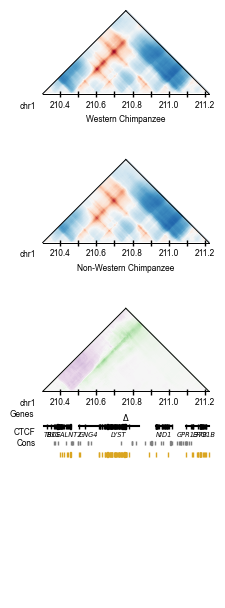

In [23]:
western_chimpanzee_divergent_window_map_comparison('SeppToni','Gamin','chr1_210239488','yes')

Comparisons saved.


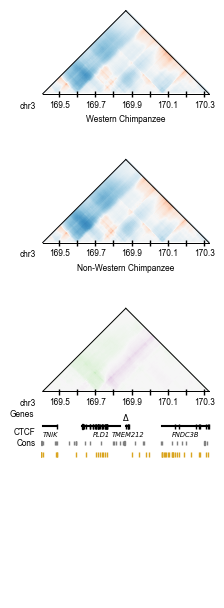

In [24]:
western_chimpanzee_divergent_window_map_comparison('Jimmie','Tongo','chr3_169345024','yes')

Comparisons saved.


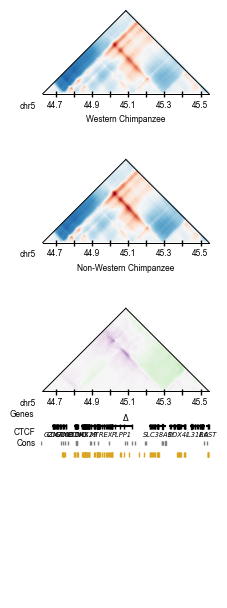

In [25]:
western_chimpanzee_divergent_window_map_comparison('Koby','Hermien','chr5_44564480','yes')

Comparisons saved.


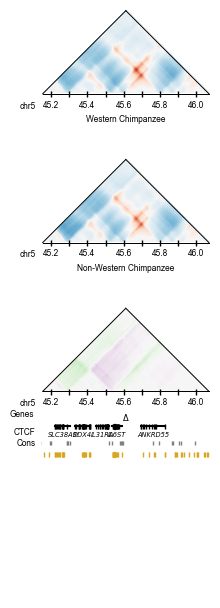

In [26]:
western_chimpanzee_divergent_window_map_comparison('Jimmie','Cindy-schwein','chr5_45088768','yes')

Comparisons saved.


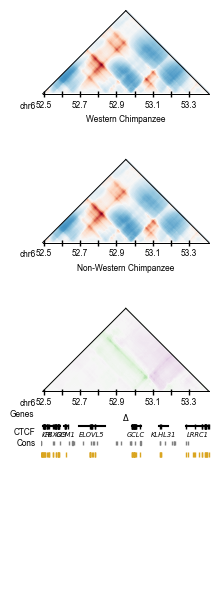

In [27]:
western_chimpanzee_divergent_window_map_comparison('Bosco','Julie-A959','chr6_52428800','yes')

Comparisons saved.


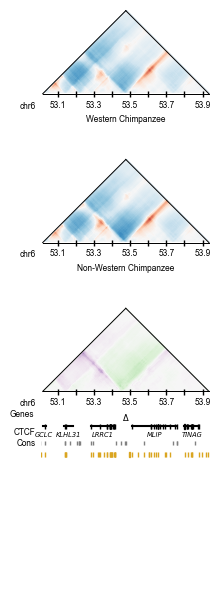

In [28]:
western_chimpanzee_divergent_window_map_comparison('Bosco','Kumbuka','chr6_52953088','yes')

Comparisons saved.


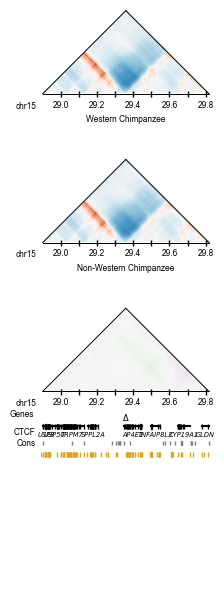

In [29]:
western_chimpanzee_divergent_window_map_comparison('Bosco','Mirinda','chr15_28835840','yes')

Comparisons saved.


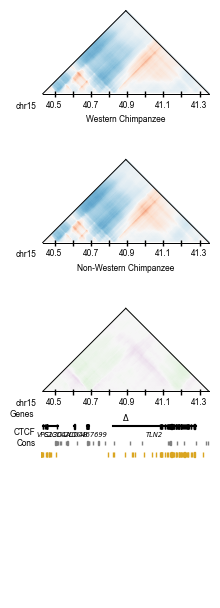

In [30]:
western_chimpanzee_divergent_window_map_comparison('Clint','Andromeda','chr15_40370176','yes')

## Example Bonobo-Chimpanzee Divergent Window Comparisons <a class = 'anchor' id = 'examplebonobochimpanzeecomparisons'></a>

In [31]:
def interspecific_clustering_map_comparison(ind1, ind2, window):
    chr = window.split('_')[0]
    start = int(window.split('_')[1])
    
    ind1_mat = load_individual_map(chr, start, ind1)
    ind2_mat = load_individual_map(chr, start, ind2)

    fig1, axes = plt.subplots(3, 1, figsize=(2,4.8))

    fig1.delaxes(axes[0])
    fig1.delaxes(axes[1])
    fig1.delaxes(axes[2])
    
    ax0 = setup_axes1(fig1, 311, -45)
    ax1 = setup_axes1(fig1, 312, -45)
    ax2 = setup_axes1(fig1, 313, -45)

    ax0.set_position([0, 0.66, 1, 1])
    ax1.set_position([0, 0.33, 1, 1])
    ax2.set_position([0, 0, 1, 1])
    
    ax0.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -2, vmax = 2)
    ax1.matshow(ind2_mat, cmap = 'RdBu_r', vmin = -2, vmax = 2)
    ax2.matshow(ind2_mat - ind1_mat, cmap = 'PRGn_r', vmin = -1, vmax = 1)
    
    subplots = [ax0,ax1,ax2]
    
    # add border to map
    for n in subplots:
        n.plot([-1, 447], [0, 448], color = 'black', linewidth = 0.70821529745) # bottom line
        n.plot([-1, 447], [448, 448], color = 'black', linewidth = 0.70821529745) # right line
        n.plot([-1, -1], [448, 0], color = 'black', linewidth = 0.70821529745) # left line
    
    # add 'x-axis' ticks
    first = start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/2048
    
    x_list = np.arange(cell, 440, (100000/2048))
        
    for n in subplots:
        for x in x_list:
            n.plot(x, x, color = 'black', marker = '|', markersize = 5)
    
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for n in subplots:
        for x, y in zip(x_list[::2], (y_list[::2])):
            n.text(x+15, x-15, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontproperties = arial, fontsize = 7)
    
    # subpanel labels
    ax0.text(290, 158, 'Chimpanzee', horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 8)
    ax1.text(290, 158, 'Bonobo', horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 8)
    ax2.text(290, 158, r'$\Delta$', horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 8)
    
    plt.savefig('/wynton/group/capra/projects/pan_3d_genome/figures/suppl_figs/interspecific_clustering_comparison_%s_%s_%s.pdf' % (window, ind1, ind2), bbox_inches = 'tight', transparent = True, dpi = 400);
    plt.show()

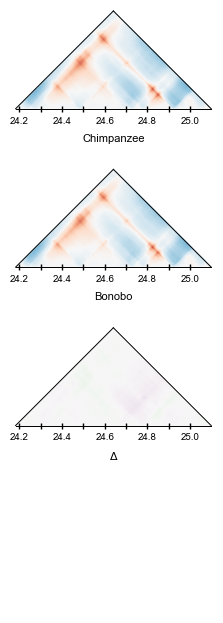

In [32]:
interspecific_clustering_map_comparison('Koto','Bono','chr21_24117248')

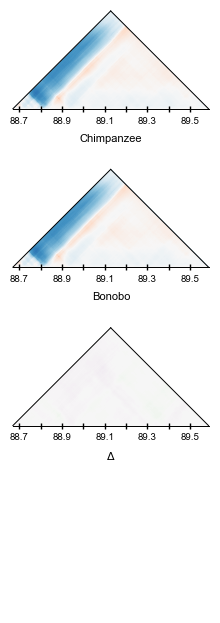

In [33]:
interspecific_clustering_map_comparison('Kidongo', 'Kosana', 'chr3_88604672')

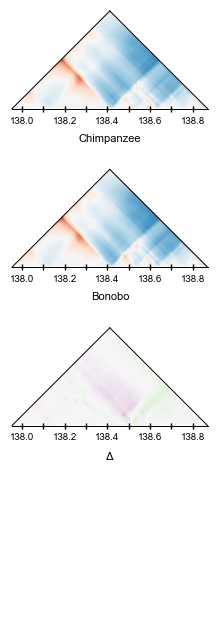

In [34]:
interspecific_clustering_map_comparison('Linda', 'Hermien', 'chr7_137887744')

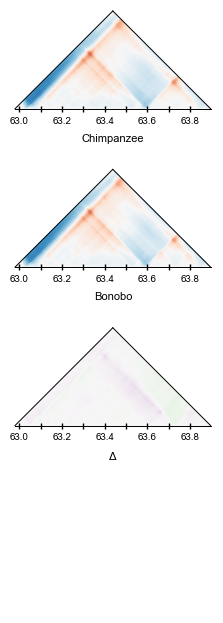

In [35]:
interspecific_clustering_map_comparison('Luky', 'Dzeeta', 'chr9_62914560')

## *MYO10* Bonobo-Chimpanzee Comparison <a class = 'anchor' id = 'myo10comparison'></a>

Write a function to add annotations to a plot. Annotations include the genes, phastCons conserved elements, and CTCF binding sites from Schwalie et al. 2013.

In [36]:
def map_comparison_no_delta_with_annotations(ind1, ind2, window, save):
    chr = window.split('_')[0]
    start = int(window.split('_')[1])

    ind1_mat = load_individual_map(chr, start, ind1)
    ind2_mat = load_individual_map(chr, start, ind2)
    
    #fig1, axes = plt.subplots(2, figsize=(20,20))
    fig1, axes = plt.subplots(2, 1, figsize=(4.8,6.8))
    
    fig1.delaxes(axes[0])
    fig1.delaxes(axes[1])
    
    #ax0 = setup_axes1(fig1, 131, -45)
    #ax1 = setup_axes1(fig1, 132, -45)
    ax0 = setup_axes1(fig1, 211, -45)
    ax1 = setup_axes1(fig1, 212, -45)


    ax0.set_position([0, 0.43, 1, 1])
    ax1.set_position([0, 0, 1, 1])
    
    ax0.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -2, vmax = 2)
    ax1.matshow(ind2_mat, cmap = 'RdBu_r', vmin = -2, vmax = 2)
    
    subplots = [ax0,ax1]
    
    # add border to map
    for n in subplots:
        n.plot([-1, 447], [0, 448], color = 'black', linewidth = 1) # bottom line
        n.plot([-1, 447], [448, 448], color = 'black', linewidth = 1) # right line
        n.plot([-1, -1], [448, 0], color = 'black', linewidth = 1) # left line
    
    # add 'x-axis' ticks
    first = start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/2048
    
    x_list = np.arange(cell, 440, (100000/2048))
        
    for n in subplots:
        for x in x_list:
            n.plot(x, x, color = 'black', marker = '|', markersize = 15*0.75)
    
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for n in subplots:
        for x, y in zip(x_list[::2], (y_list[::2])):
            n.text(x+18, x-18, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontproperties = arial, fontsize = 9)
    
    # get annotations
    exon_starts, exon_lengths, gene_starts, gene_lengths, gene_midpoints, exon_genes, phastCons_starts, phastCons_lengths, CTCF_starts, CTCF_lengths = annotations(chr, start)
    
    # plot tracks
    for x, y in zip(exon_starts, exon_lengths):
        ax1.add_patch(Rectangle((x+70, x-70), width = y, height = 25*0.75, angle = 45, color = 'black', lw = 1))
    for x, y in zip(gene_starts, gene_lengths):
        ax1.plot([(x+63.5), ((x+y)+63.5)],[(x-63.5), ((x+y)-63.5)], color = 'black') # line will default to bottom of exon rectangle so adjust coordinates if exon height changes
    for x, y in zip(gene_midpoints, exon_genes):
        ax1.text(x+75, x-75, y, horizontalalignment = 'center', verticalalignment = 'top', style = 'italic', fontsize = 8)
    for x, y in zip(CTCF_starts, CTCF_lengths):
        ax1.add_patch(Rectangle((x+115, x-115), width = y, height = 25*0.75, angle = 45, color = 'grey', lw = 1))
    for x, y in zip(phastCons_starts, phastCons_lengths):
        ax1.add_patch(Rectangle((x+145, x-145), width = y, height = 25*0.75, angle = 45, color = 'goldenrod', lw = 1))

    # track labels
    for n in subplots:
        n.text(0, -36, chr, horizontalalignment = 'right', verticalalignment = 'top', fontproperties = arial, fontsize = 10)
    # track labels
    ax1.text(37.5, -82.5, 'Genes', horizontalalignment = 'right', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    ax1.text(87.5, -127.5, 'CTCF', horizontalalignment = 'right', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    ax1.text(117.5, -157.5, 'Cons', horizontalalignment = 'right', verticalalignment = 'center', fontproperties = arial, fontsize = 10)

    plt.subplots_adjust(hspace=0.5)
    
    # save and show plot
    if save == 'yes':
        plt.savefig('/wynton/group/capra/projects/pan_3d_genome/figures/main_fig_components/annotated_comparison_%s_%s_%s.pdf' % (window, ind1, ind2), bbox_inches = 'tight', transparent = True)
        print('Comparisons saved.')
    plt.show()

Comparisons saved.


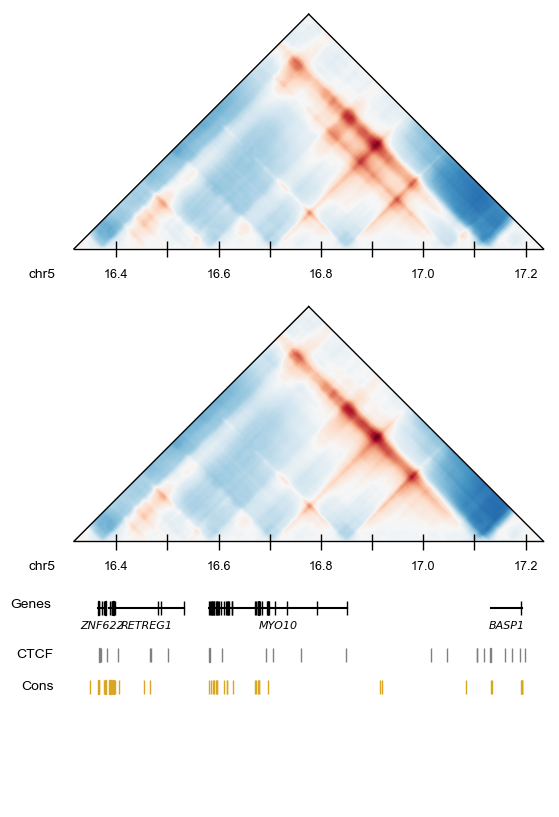

In [37]:
map_comparison_no_delta_with_annotations('Clint', 'Hortense', 'chr5_16252928', 'yes')

## *In Silico* Mutagenesis Map Comparison <a class = 'anchor' id = 'insilicomutagenesiscomparison'></a>

In [38]:
def alternate_map(window, variant):
    chr = window.split('_')[0]
    start = int(window.split('_')[1])
    
    with open('/wynton/group/capra/projects/pan_3d_genome/data/in_silico_mutagenesis/ppn_ptr_divergent_window_3d_modifying_variant_predictions/%s_%s_%s.txt' % (chr, variant, window)) as alt_file:
        lines = [ line.strip() for line in alt_file ]
        for line in lines:
            line = line.split('\t')
            alt_vector = line[2:]
            #print(alt_vector)
    alt_mat = from_upper_triu(alt_vector, 448, 2)
    mask = np.tri(alt_mat.shape[0], k = -1)
    alt_mat = np.ma.array(alt_mat, mask = mask).T
    return alt_mat

In [39]:
def in_silico_mutagenesis_map_comparison(ind1, ind2, window, variant, save):
    chr = window.split('_')[0]
    start = int(window.split('_')[1])

    ind1_mat = load_individual_map(chr, start, ind1)
    alt_mat = alternate_map(window, variant)
    ind2_mat = load_individual_map(chr, start, ind2)
    
    fig1, axes = plt.subplots(3, 1, figsize=(4.8,9))

    fig1.delaxes(axes[0])
    fig1.delaxes(axes[1])
    fig1.delaxes(axes[2])
    
    ax0 = setup_axes1(fig1, 311, -45)
    ax1 = setup_axes1(fig1, 312, -45)
    ax2 = setup_axes1(fig1, 313, -45)

    ax0.set_position([0, 0.66, 1, 1])
    ax1.set_position([0, 0.33, 1, 1])
    ax2.set_position([0, 0, 1, 1])
    
    ax0.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -1.5, vmax = 1.5)
    ax1.matshow(alt_mat, cmap = 'RdBu_r', vmin = -1.5, vmax = 1.5)
    ax2.matshow(ind2_mat, cmap = 'RdBu_r', vmin = -1.5, vmax = 1.5)
    
    subplots = [ax0,ax1,ax2]
    
    # add border to map
    for n in subplots:
        n.plot([-1, 447], [0, 448], color = 'black', linewidth = 1) # bottom line
        n.plot([-1, 447], [448, 448], color = 'black', linewidth = 1) # right line
        n.plot([-1, -1], [448, 0], color = 'black', linewidth = 1) # left line
    
    # add 'x-axis' ticks
    first = start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/2048
    
    x_list = np.arange(cell, 440, (100000/2048))
        
    for n in subplots:
        for x in x_list:
            n.plot(x, x, color = 'black', marker = '|', markersize = 15 * 0.75)
    
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for n in subplots:
        for x, y in zip(x_list[::2], (y_list[::2])):
            n.text(x+21, x-21, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontproperties = arial, fontsize = 9)

    # variant position
    variant_diff = variant - first
    variant_cell = variant_diff/2048
    
    for n in subplots:
        n.scatter(variant_cell+9, variant_cell-9, marker = '*', s = 150, c = '#d80000', edgecolors = 'none', zorder = 10)
        n.scatter(variant_cell+9, variant_cell-9, marker = '*', s = 150, c = 'none', edgecolors = 'black', linewidths = 1, zorder = 8)
            
    # get annotations
    exon_starts, exon_lengths, gene_starts, gene_lengths, gene_midpoints, exon_genes, phastCons_starts, phastCons_lengths, CTCF_starts, CTCF_lengths = annotations(chr, start)

    # plot tracks
    for x, y in zip(exon_starts, exon_lengths):
        ax2.add_patch(Rectangle((x+70, x-70), width = y, height = 25 * 0.75, angle = 45, color = 'black', lw = 1))
    for x, y in zip(gene_starts, gene_lengths):
        ax2.plot([(x+63.5), ((x+y)+63.5)],[(x-63.5), ((x+y)-63.5)], color = 'black') # line will default to bottom of exon rectangle so adjust coordinates if exon height changes
    for x, y in zip(gene_midpoints, exon_genes):
        ax2.text(x+75, x-75, y, horizontalalignment = 'center', verticalalignment = 'top', style = 'italic', fontsize = 7)
    for x, y in zip(CTCF_starts, CTCF_lengths):
        ax2.add_patch(Rectangle((x+115, x-115), width = y, height = 25 * 0.75, angle = 45, color = 'grey', lw = 1))
    for x, y in zip(phastCons_starts, phastCons_lengths):
        ax2.add_patch(Rectangle((x+145, x-145), width = y, height = 25 * 0.75, angle = 45, color = 'goldenrod', lw = 1))

    # track labels
    for n in subplots:
        n.text(0, -42, chr, horizontalalignment = 'right', verticalalignment = 'top', fontproperties = arial, fontsize = 10)
    ax2.text(37.5, -82.5, 'Genes', horizontalalignment = 'right', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    ax2.text(87.5, -127.5, 'CTCF', horizontalalignment = 'right', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    ax2.text(117.5, -157.5, 'Cons', horizontalalignment = 'right', verticalalignment = 'center', fontproperties = arial, fontsize = 10)

    # save and show plot
    if save == 'yes':
        plt.savefig('/wynton/group/capra/projects/pan_3d_genome/figures/main_fig_components/in_silico_mutagenesis_comparison_%s_%s_%s_%s.pdf' % (window, variant, ind1, ind2), bbox_inches = 'tight', transparent = True)
        print('Comparisons saved.')
    plt.show()

Comparisons saved.


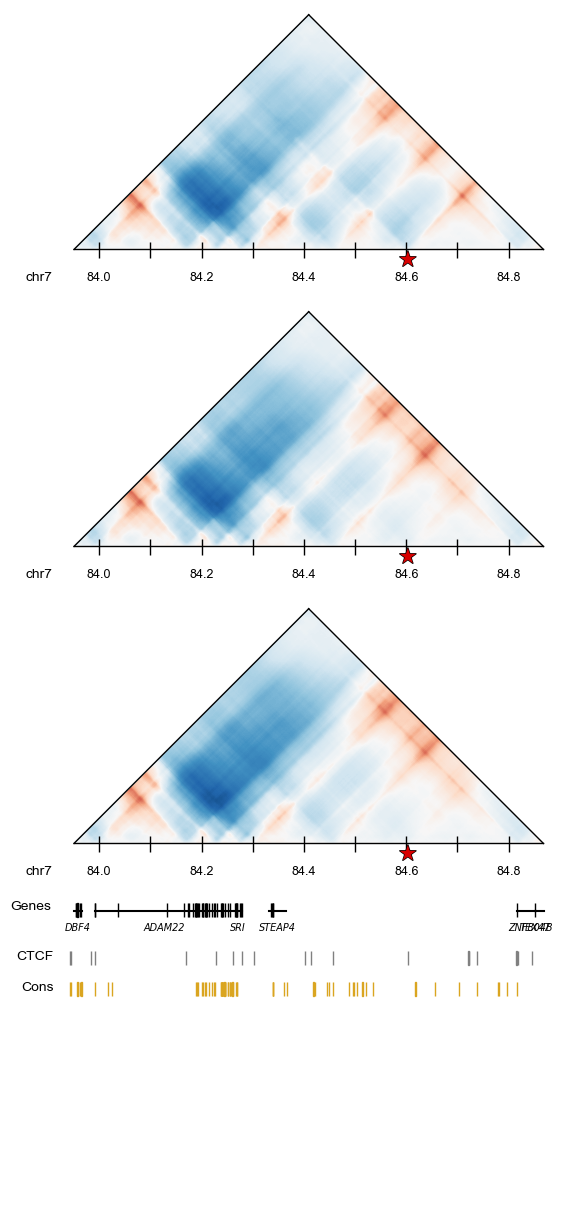

In [40]:
in_silico_mutagenesis_map_comparison('Ula', 'Desmond', 'chr7_83886080', 84603122, 'yes')